In [1]:
import numpy as np
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

class Simple_Kalman:

    def __init__(self, observation, start_position, start_deviation, deviation_true, deviation_noise):

        self.obs = observation
        self.n_obs = len(observation)
        self.start_pos = start_position
        self.start_dev = start_deviation
        self.dev_q = deviation_true
        self.dev_r = deviation_noise

        self._fit()


    def _forward(self):

        self.x_prev_ = [self.start_pos]
        self.P_prev_ = [self.start_dev]
        self.K_ = [self.P_prev_[0] / (self.P_prev_[0] + self.dev_r)]
        self.P_ = [self.dev_r * self.P_prev_[0] / (self.P_prev_[0] + self.dev_r)]
        self.x_ = [self.x_prev_[0] + self.K_[0] * (self.obs[0] - self.x_prev_[0])]

        for t in range(1, self.n_obs):
            self.x_prev_.append(self.x_[t-1])
            self.P_prev_.append(self.P_[t-1] + self.dev_q)

            self.K_.append(self.P_prev_[t] / (self.P_prev_[t] + self.dev_r))
            self.x_.append(self.x_prev_[t] + self.K_[t] * (self.obs[t] - self.x_prev_[t]))
            self.P_.append(self.dev_r * self.P_prev_[t] / (self.P_prev_[t] + self.dev_r))


    def _backward(self):

        self.x_all_ = [self.x_[-1]]
        self.P_all_ = [self.P_[-1]]
        self.C_ = [self.P_[-1] / (self.P_[-1] + self.dev_q)]

        for t in range(2, self.n_obs + 1):
            self.C_.append(self.P_[-t] / (self.P_[-t] + self.dev_q))
            self.x_all_.append(self.x_[-t] + self.C_[-1] * (self.x_all_[-1] - self.x_prev_[-t+1]))
            self.P_all_.append(self.P_[-t] + (self.C_[-1]**2) * (self.P_all_[-1] - self.P_prev_[-t+1]))

        self.C_.reverse()
        self.x_all_.reverse()
        self.P_all_.reverse()


    def _fit(self):
        self._forward()
        self._backward()
            
print('==>Kalman Filter imported')

==>Kalman Filter imported


In [2]:
#read train data
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn
import random
import keras

from pathlib import Path
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.neighbors import NearestNeighbors

#read csv data as frame
path = Path(r'D:/datasets/exoplanets')
print('windowspath:',path)
path.glob('*')
list(path.glob('*'))
path=list(path.glob('*'))[1]
print('windowspath:',path)
#data=pd.read_csv(path,header=None, delimiter='\t')
#data.head()
data=pd.read_csv(path,delimiter=',')
data.info()
#datat=data.transpose()
#df.head()
#df=df.drop(df.index[0])


Using TensorFlow backend.
C:\Users\si\Anaconda3\envs\tf-cpu3.6\lib\site-packages\tensorflow\python\framework\dtypes.py:519: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\Users\si\Anaconda3\envs\tf-cpu3.6\lib\site-packages\tensorflow\python\framework\dtypes.py:520: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\Users\si\Anaconda3\envs\tf-cpu3.6\lib\site-packages\tensorflow\python\framework\dtypes.py:521: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
C:\Users\si\Anaconda3\envs\tf-cpu3.6\lib\sit

windowspath: D:\datasets\exoplanets
windowspath: D:\datasets\exoplanets\exoTrain.csv
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5087 entries, 0 to 5086
Columns: 3198 entries, LABEL to FLUX.3197
dtypes: float64(3197), int64(1)
memory usage: 124.1 MB


In [3]:
df=data
df.LABEL
df[df.LABEL<3]

,LABEL,FLUX.1,FLUX.2,FLUX.3,FLUX.4,FLUX.5,FLUX.6,FLUX.7,FLUX.8,FLUX.9,...,FLUX.3188,FLUX.3189,FLUX.3190,FLUX.3191,FLUX.3192,FLUX.3193,FLUX.3194,FLUX.3195,FLUX.3196,FLUX.3197
0,2,93.85,83.81,20.10,-26.98,-39.56,-124.71,-135.18,-96.27,-79.89,...,-78.07,-102.15,-102.15,25.13,48.57,92.54,39.32,61.42,5.08,-39.54
1,2,-38.88,-33.83,-58.54,-40.09,-79.31,-72.81,-86.55,-85.33,-83.97,...,-3.28,-32.21,-32.21,-24.89,-4.86,0.76,-11.70,6.46,16.00,19.93
2,2,532.64,535.92,513.73,496.92,456.45,466.00,464.50,486.39,436.56,...,-71.69,13.31,13.31,-29.89,-20.88,5.06,-11.80,-28.91,-70.02,-96.67
3,2,326.52,347.39,302.35,298.13,317.74,312.70,322.33,311.31,312.42,...,5.71,-3.73,-3.73,30.05,20.03,-12.67,-8.77,-17.31,-17.35,13.98
4,2,-1107.21,-1112.59,-1118.95,-1095.10,-1057.55,-1034.48,-998.34,-1022.71,-989.57,...,-594.37,-401.66,-401.66,-357.24,-443.76,-438.54,-399.71,-384.65,-411.79,-510.54
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5082,1,-91.91,-92.97,-78.76,-97.33,-68.00,-68.24,-75.48,-49.25,-30.92,...,139.95,147.26,156.95,155.64,156.36,151.75,-24.45,-17.00,3.23,19.28
5083,1,989.75,891.01,908.53,851.83,755.11,615.78,595.77,458.87,492.84,...,-26.50,-4.84,-76.30,-37.84,-153.83,-136.16,38.03,100.28,-45.64,35.58
5084,1,273.39,278.00,261.73,236.99,280.73,264.90,252.92,254.88,237.60,...,-26.82,-53.89,-48.71,30.99,15.96,-3.47,65.73,88.42,79.07,79.43
5085,1,3.82,2.09,-3.29,-2.88,1.66,-0.75,3.85,-0.03,3.28,...,10.86,-3.23,-5.10,-4.61,-9.82,-1.50,-4.65,-14.55,-6.41,-2.55


In [4]:
#divied the dataframe into two groups
data1=data[data.LABEL<2]
data2=data[data.LABEL>1]
print('confirmed exoplanet-stars:',data2.shape, 'non-exoplanet-stars:', data1.shape)
len(data2.index),len(data1.index)
data2.index

confirmed exoplanet-stars: (37, 3198) non-exoplanet-stars: (5050, 3198)


Int64Index([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
            17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
            34, 35, 36],
           dtype='int64')

C:\Users\si\Anaconda3\envs\tf-cpu3.6\lib\site-packages\ipykernel_launcher.py:24: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
C:\Users\si\Anaconda3\envs\tf-cpu3.6\lib\site-packages\ipykernel_launcher.py:24: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
C:\Users\si\Anaconda3\envs\tf-cpu3.6\lib\site-packages\ipykernel_launcher.py:24: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this war

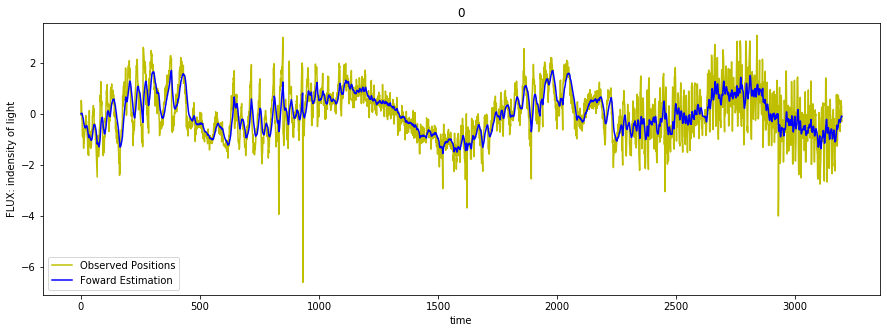

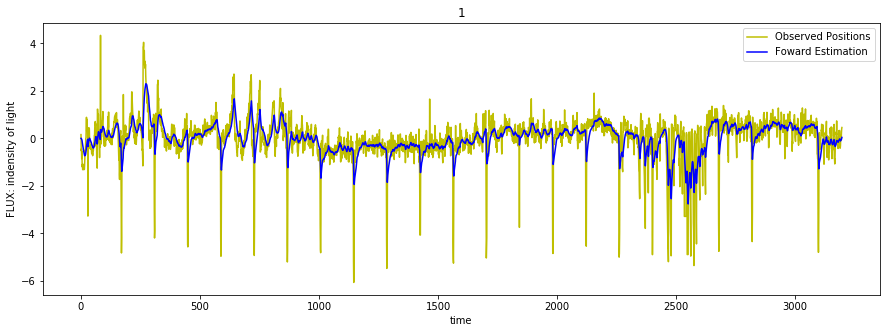

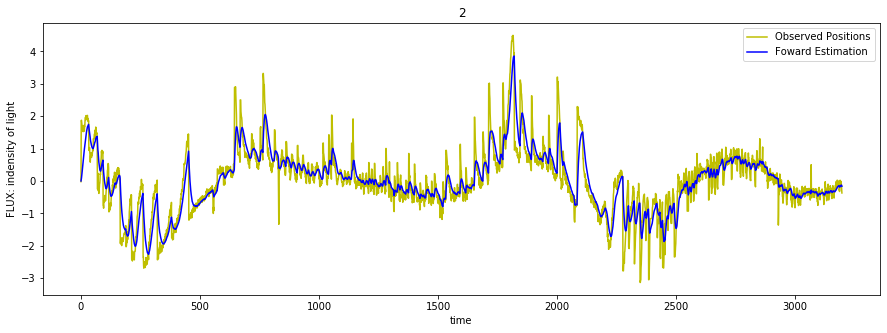

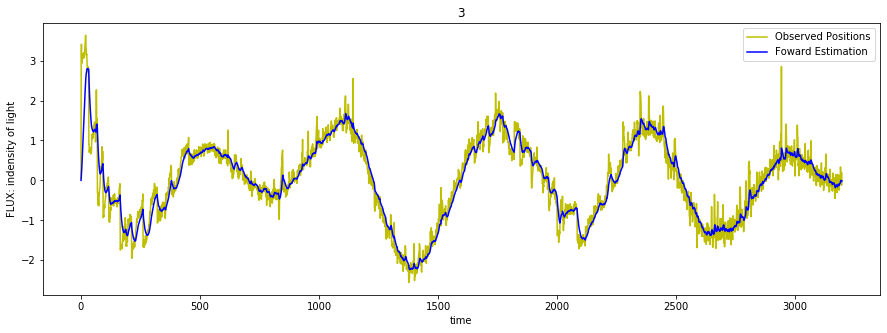

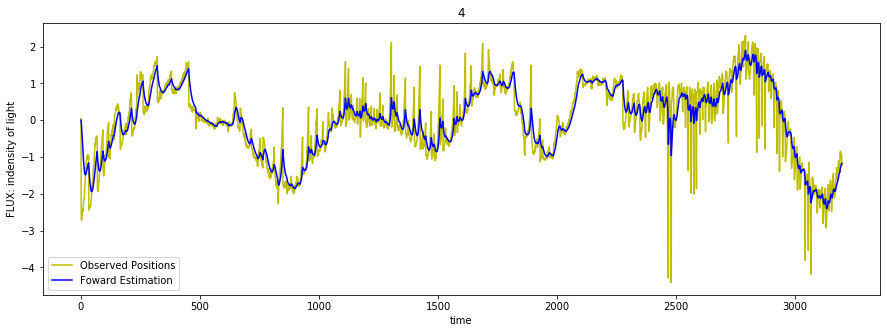

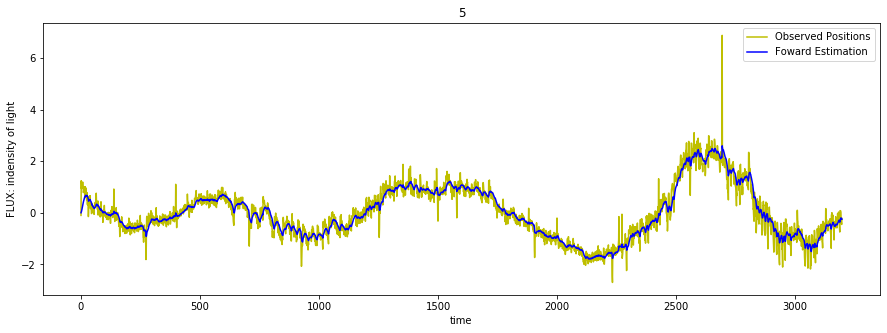

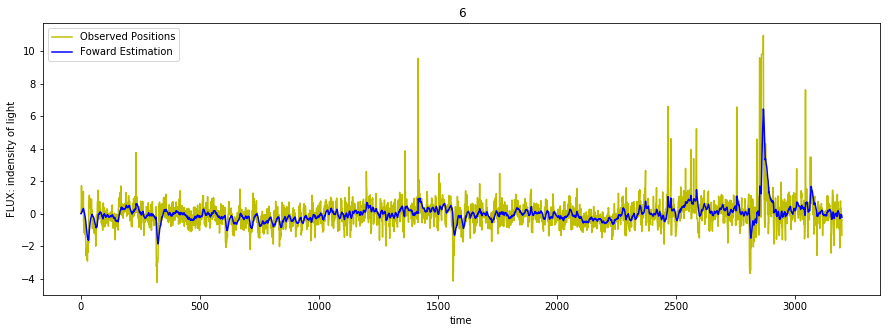

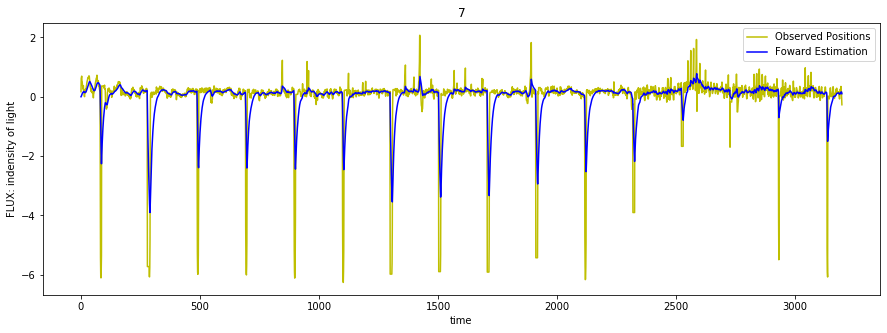

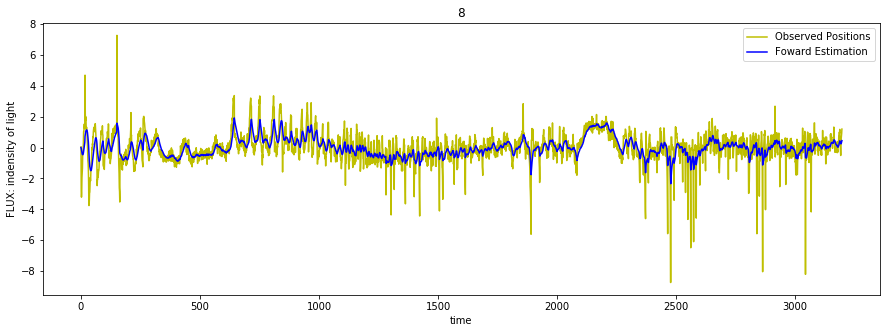

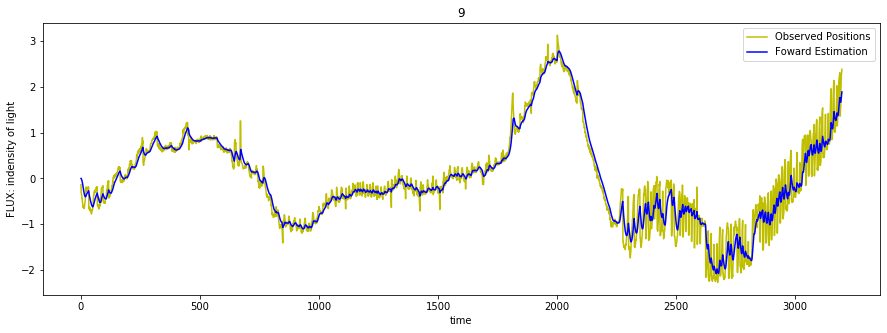

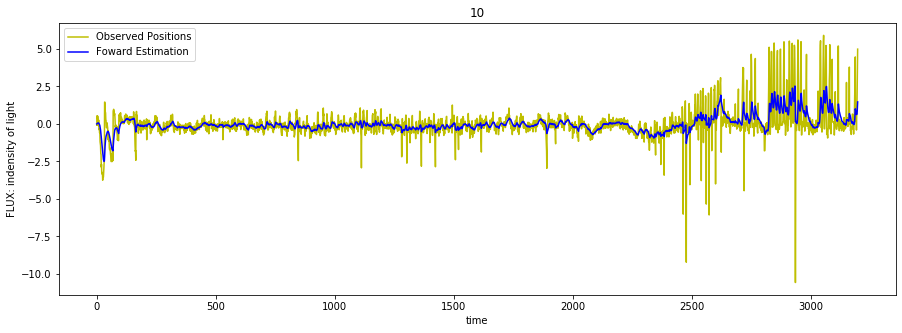

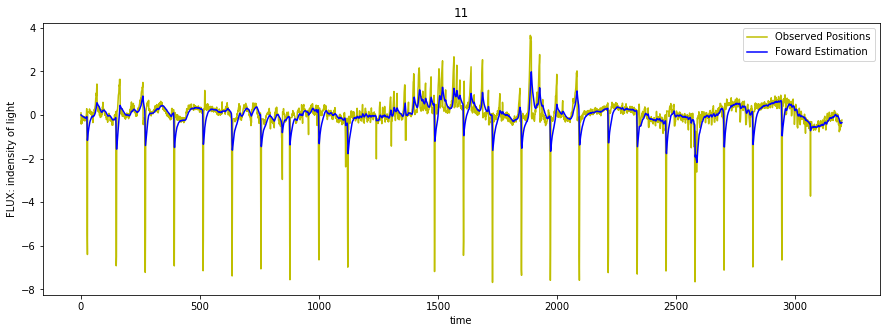

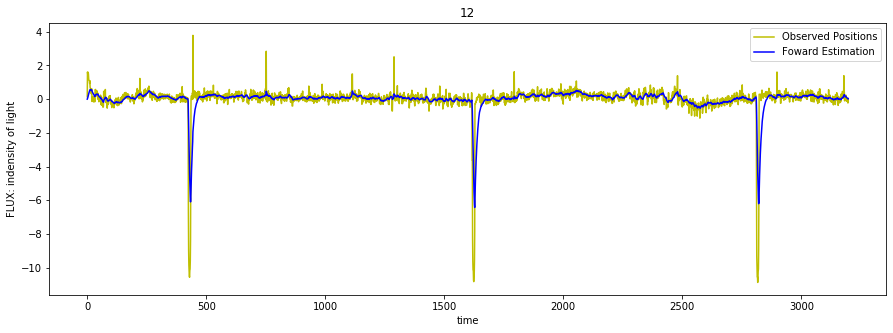

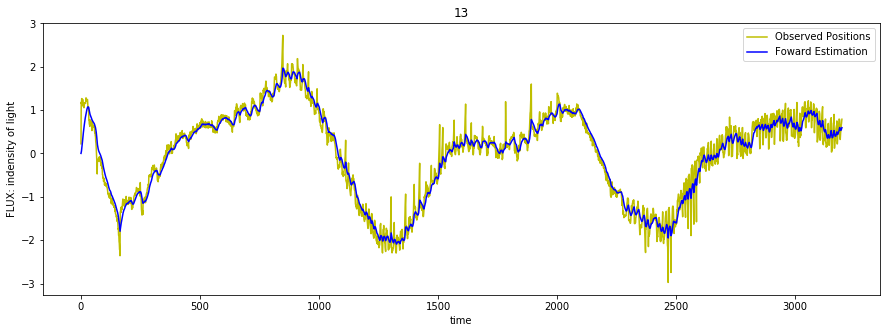

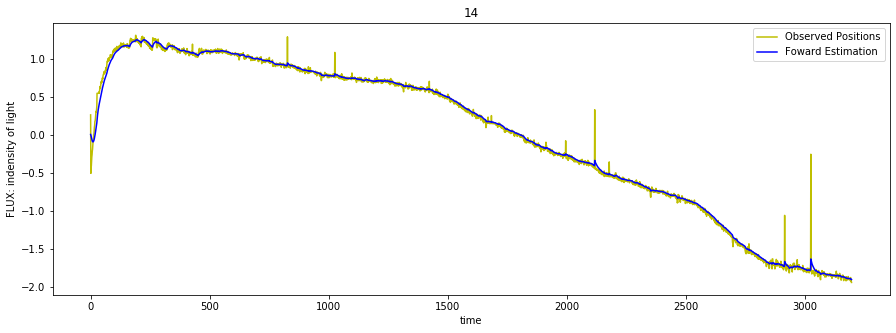

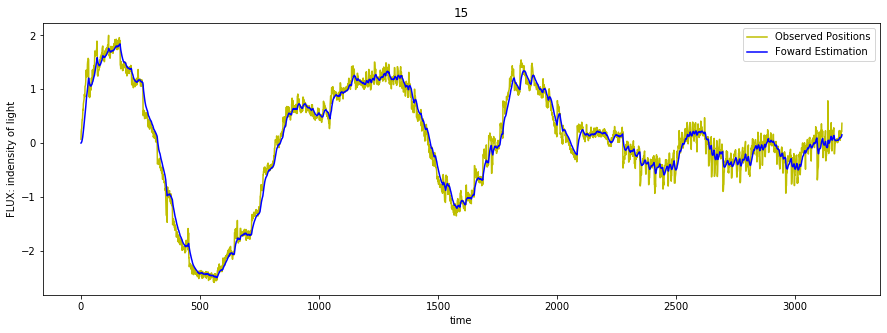

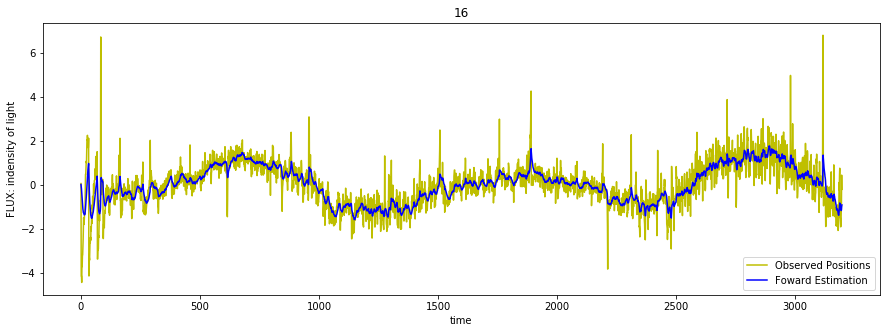

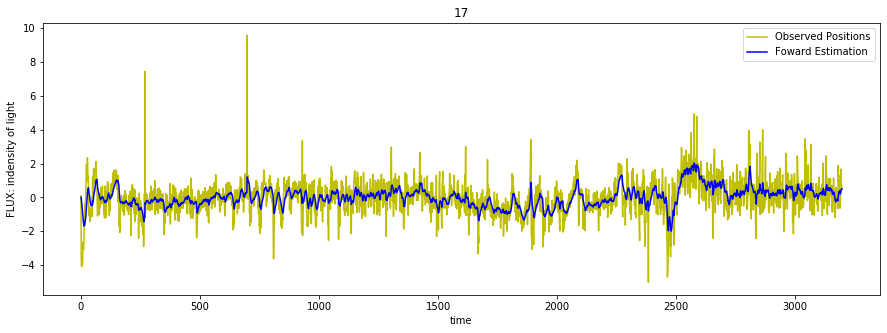

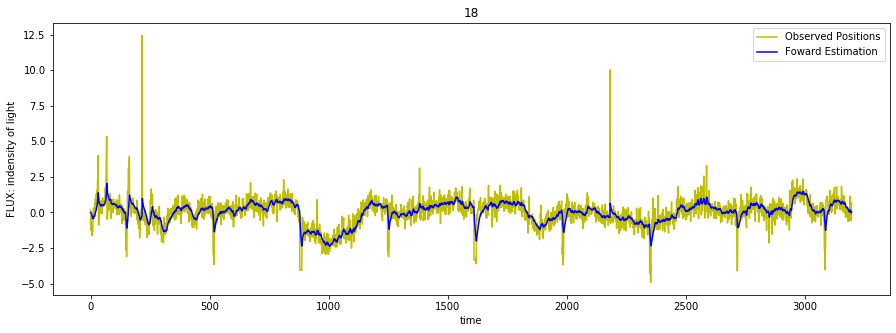

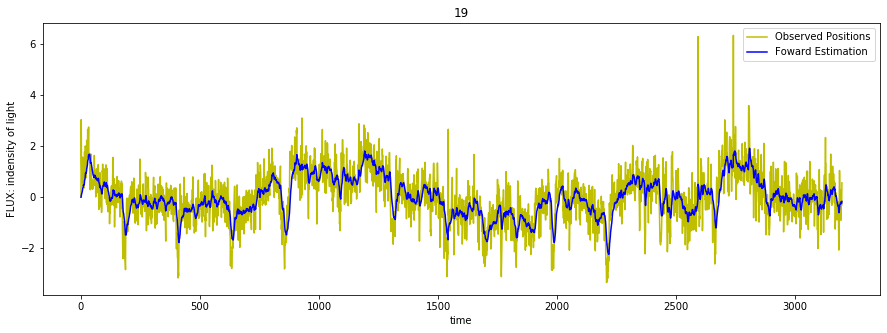

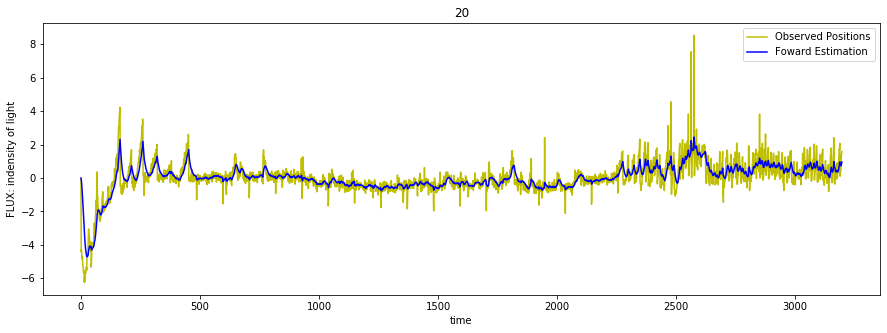

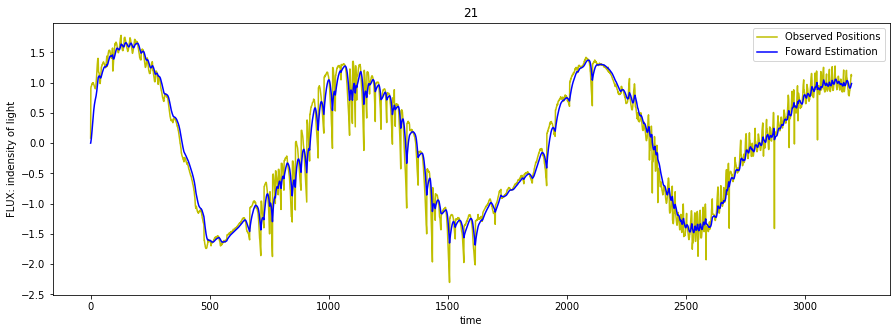

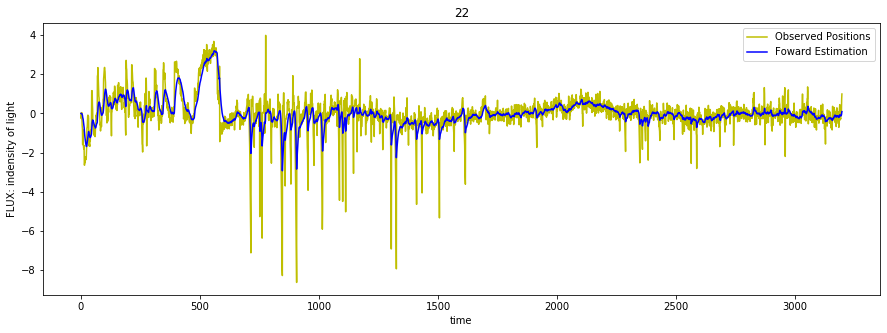

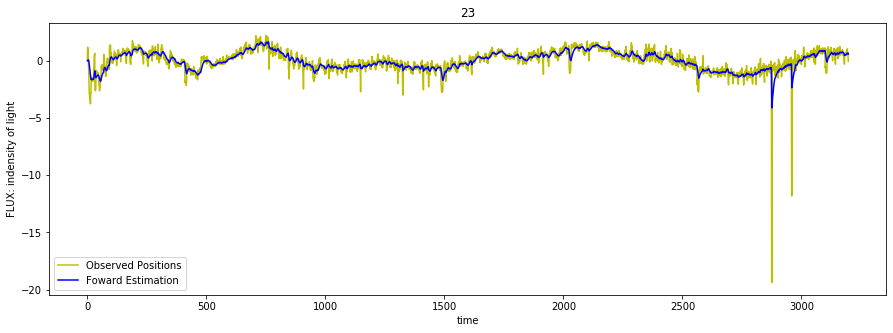

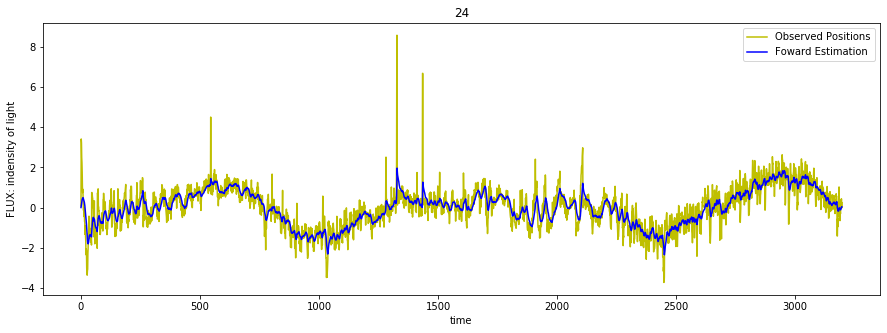

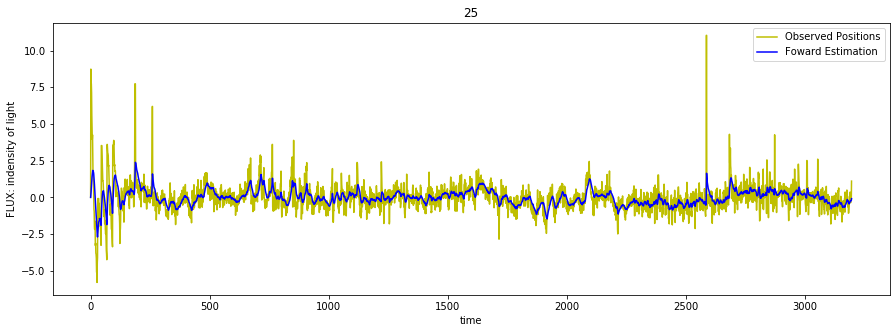

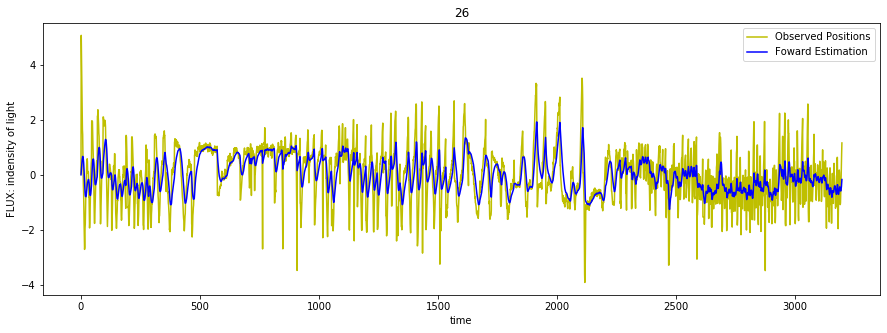

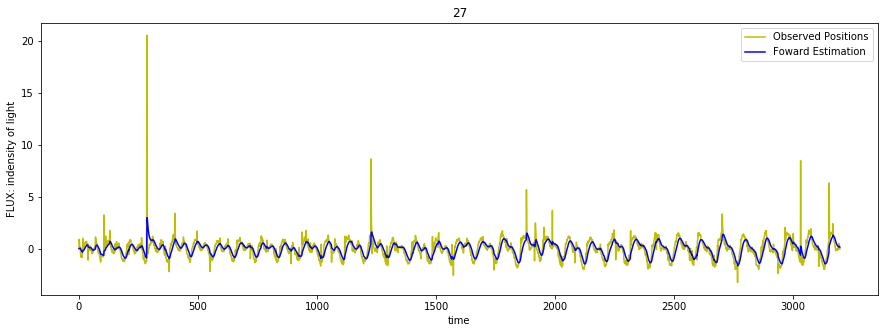

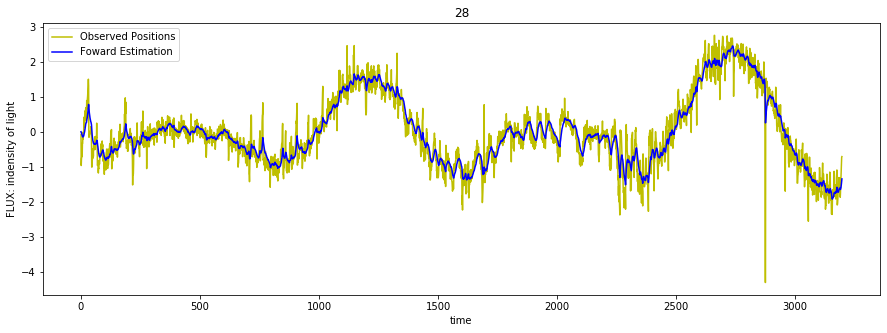

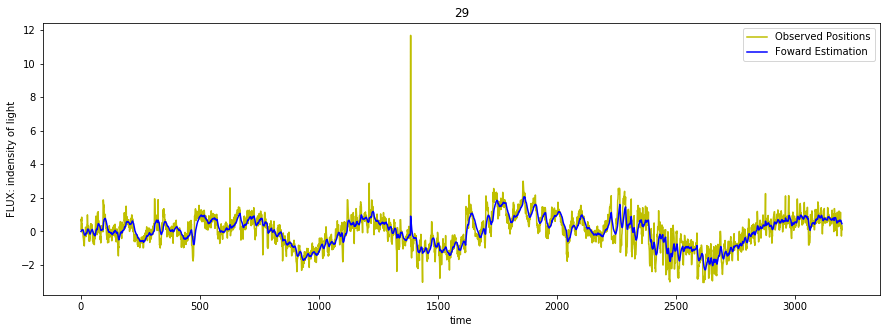

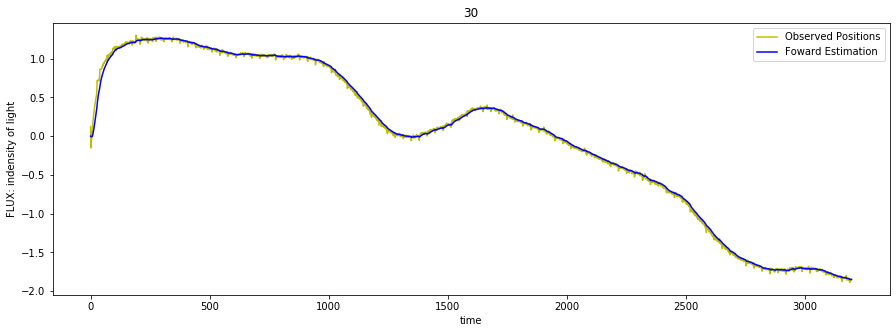

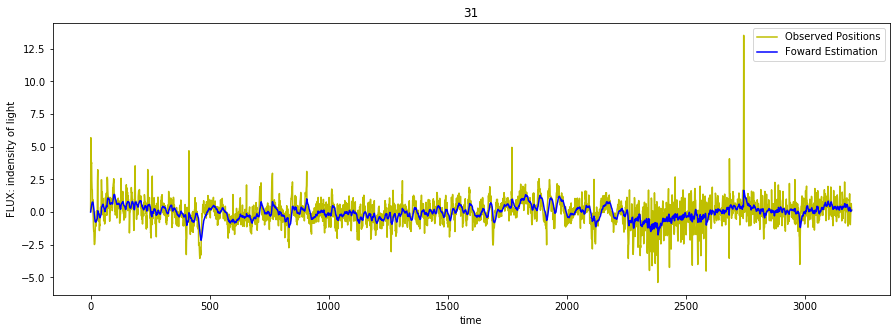

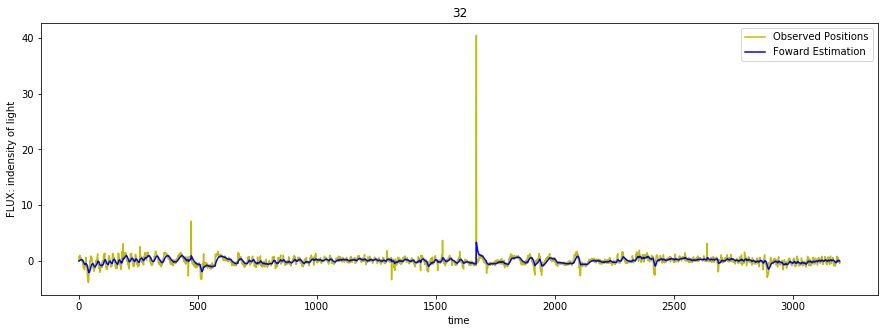

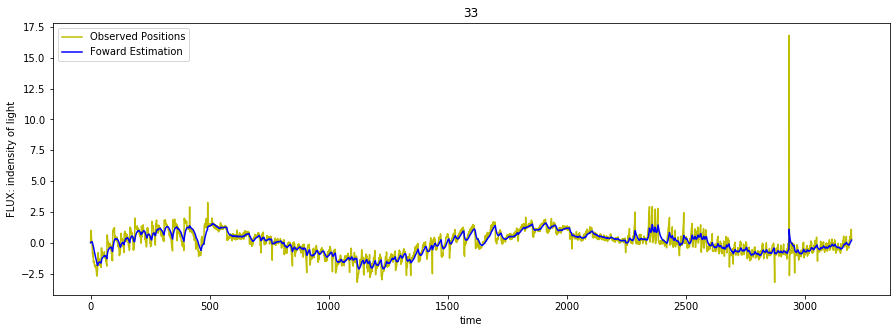

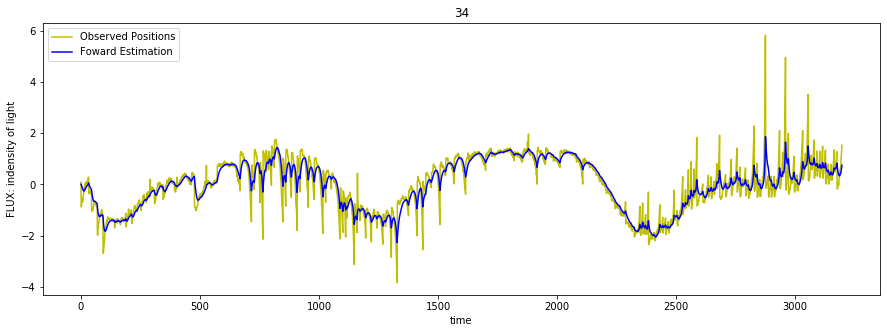

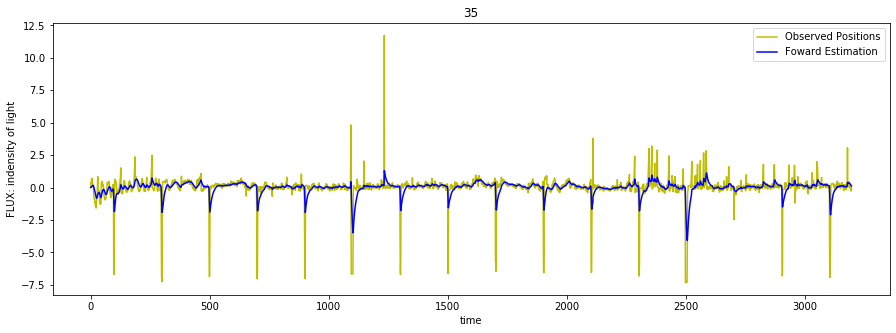

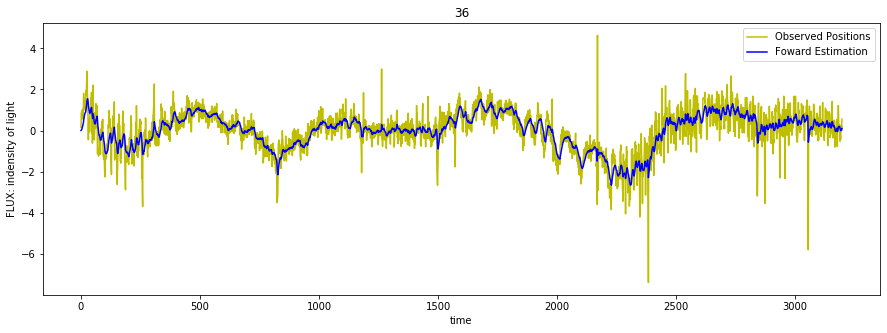

In [5]:
#standize the dataset
from sklearn.preprocessing import StandardScaler
#show data2 

#print('length of ECG data : ', len(df222))

for i in range(0, len(data2.index)):
    
    df2 = data2.loc[i]
    df22=df2.values
    df22.shape
    df222=df22.reshape(len(df22),-1)
    
    #normalization
    scalar= StandardScaler()
    data_stand2=scalar.fit_transform(df222)
    observed_position=data_stand2.reshape(len(df22))
    #Kalman Filter
    timeseries=np.arange(3198)
    kf = Simple_Kalman(observed_position, start_position=0, start_deviation=1, deviation_true=1, deviation_noise=100)


    #plt.plot(timeseries,data_stand2,color='blue')
    plt.figure(figsize=(15,5))
    plt.title(i)
    plt.xlabel('time')
    plt.ylabel('FLUX: indensity of light')
    #plt.plot(true_position, 'r--', label='True Positions')
    plt.plot(timeseries, observed_position, 'y', label='Observed Positions')
    plt.plot(kf.x_, color='blue' ,label='Foward Estimation')
    #plt.plot(kf.x_all_, 'black', label='Smoothed Estimation')
    plt.legend(loc='best')
    #print(df2.name)

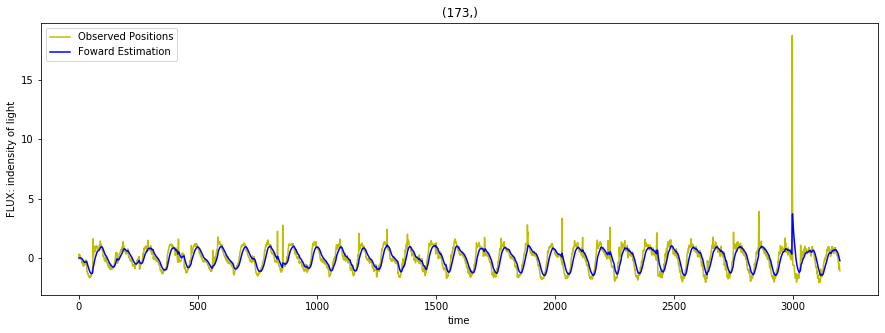

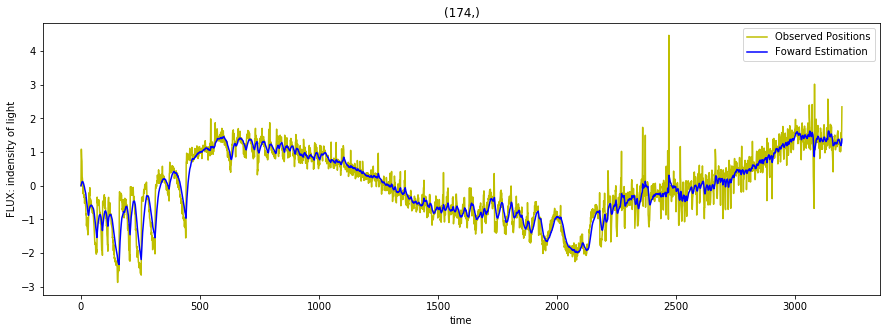

In [6]:
#plot wrong prediction samples on train data
#plot wrong prediction samples on test data
from sklearn.preprocessing import StandardScaler
#show data2 

#print('length of ECG data : ', len(df222))
data1sample=np.array([173,174])
for j in enumerate(data1sample):
    shape=data1sample.shape
    i=j[1:2] #importance! 2d array->1d array

    
    df2 = data.loc[i]
    df22=df2.values
    df22.shape
    df222=df22.reshape(len(df22),-1)
    
    #normalization
    scalar= StandardScaler()
    data_stand2=scalar.fit_transform(df222)
    observed_position=data_stand2.reshape(len(df22))
    #Kalman Filter
    timeseries=np.arange(3198)
    kf = Simple_Kalman(observed_position, start_position=0, start_deviation=1, deviation_true=1, deviation_noise=100)


    #plt.plot(timeseries,data_stand2,color='blue')
    plt.figure(figsize=(15,5))
    plt.title(i)
    plt.xlabel('time')
    plt.ylabel('FLUX: indensity of light')
    #plt.plot(true_position, 'r--', label='True Positions')
    plt.plot(timeseries, observed_position, 'y', label='Observed Positions')
    plt.plot(kf.x_, color='blue' ,label='Foward Estimation')
    #plt.plot(kf.x_all_, 'black', label='Smoothed Estimation')
    plt.legend(loc='best')
    #print(df2.name)

In [7]:
#read test data
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn
import random
import keras

from pathlib import Path
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.neighbors import NearestNeighbors

#read csv data as frame
path = Path(r'D:/datasets/exoplanets')
print('windowspath:',path)
path.glob('*')
list(path.glob('*'))
path=list(path.glob('*'))[0]
print('windowspath:',path)
#data=pd.read_csv(path,header=None, delimiter='\t')
#data.head()
data=pd.read_csv(path,delimiter=',')
data.info()
#datat=data.transpose()
#df.head()
#df=df.drop(df.index[0])


windowspath: D:\datasets\exoplanets
windowspath: D:\datasets\exoplanets\exoTest.csv
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 570 entries, 0 to 569
Columns: 3198 entries, LABEL to FLUX.3197
dtypes: float64(3197), int64(1)
memory usage: 13.9 MB


In [8]:
df2 = data.loc[124]
df2.shape

(3198,)

In [9]:
data1sample=np.array([124,246,372,460,485])
data1sample.shape
data1sample


array([124, 246, 372, 460, 485])

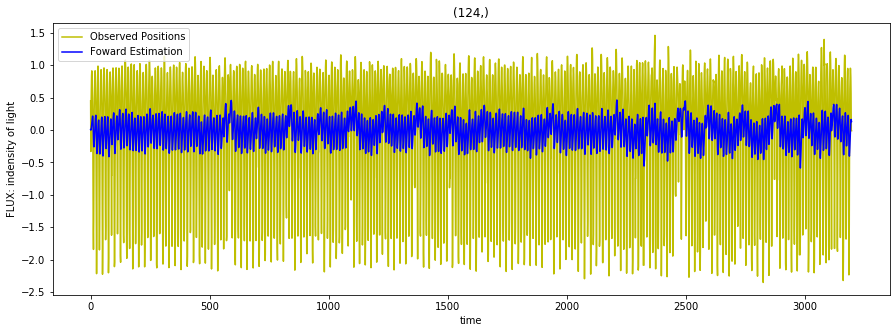

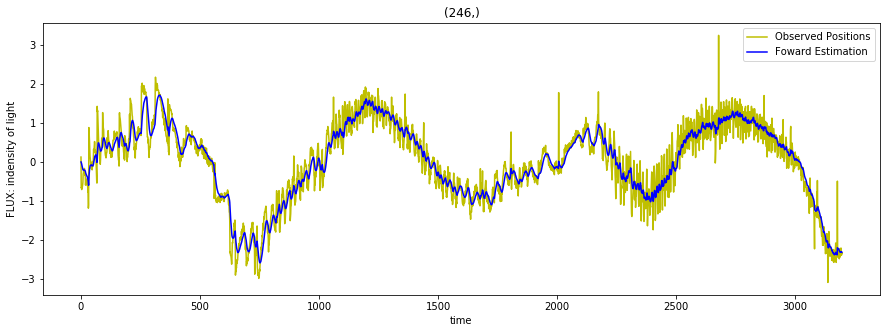

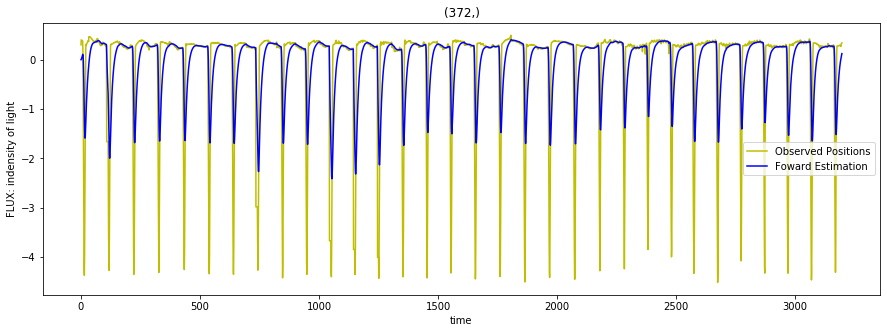

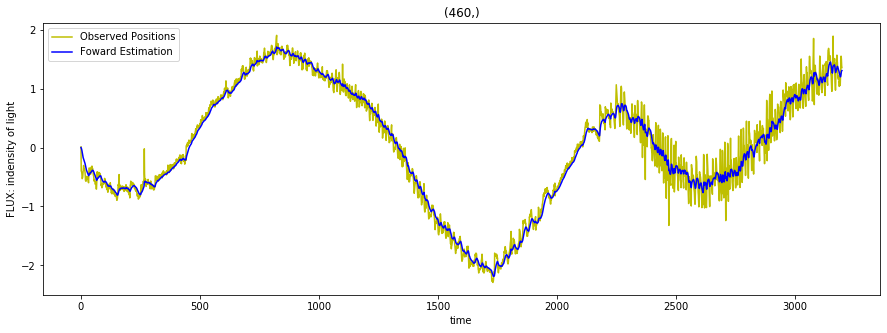

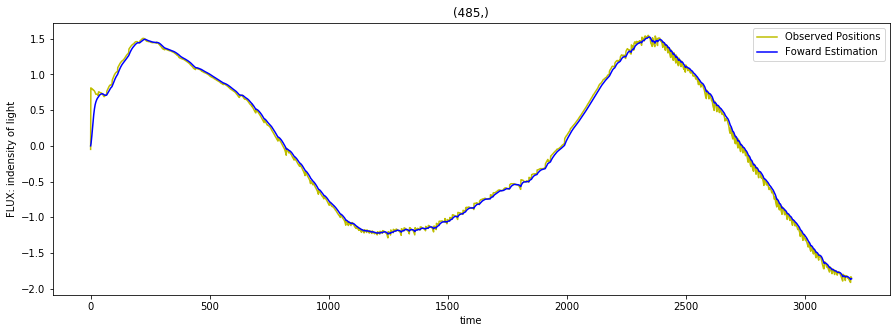

In [10]:
#plot wrong prediction samples on test data
from sklearn.preprocessing import StandardScaler
#show data2 

#print('length of ECG data : ', len(df222))
data1sample=np.array([124,246,372,460,485])
for j in enumerate(data1sample):
    shape=data1sample.shape
    i=j[1:2] #importance! 2d array->1d array

    
    df2 = data.loc[i]
    df22=df2.values
    df22.shape
    df222=df22.reshape(len(df22),-1)
    
    #normalization
    scalar= StandardScaler()
    data_stand2=scalar.fit_transform(df222)
    observed_position=data_stand2.reshape(len(df22))
    #Kalman Filter
    timeseries=np.arange(3198)
    kf = Simple_Kalman(observed_position, start_position=0, start_deviation=1, deviation_true=1, deviation_noise=100)


    #plt.plot(timeseries,data_stand2,color='blue')
    plt.figure(figsize=(15,5))
    plt.title(i)
    plt.xlabel('time')
    plt.ylabel('FLUX: indensity of light')
    #plt.plot(true_position, 'r--', label='True Positions')
    plt.plot(timeseries, observed_position, 'y', label='Observed Positions')
    plt.plot(kf.x_, color='blue' ,label='Foward Estimation')
    #plt.plot(kf.x_all_, 'black', label='Smoothed Estimation')
    plt.legend(loc='best')
    #print(df2.name)

In [11]:
#appendix

In [12]:
data1sample=np.array([124,246,372,460,485])
data1sample.shape

(5,)

In [13]:
df2 = data2.loc[1]
df22=df2.values
df22.shape
df222=df22.reshape(len(df22),-1)
scalar= StandardScaler()
data_stand2=scalar.fit_transform(df222)
data_stand2=data_stand2.reshape(len(df22))
df2.shape, df22.shape, df222.shape, data_stand2.shape

((3198,), (3198,), (3198, 1), (3198,))

In [14]:
observed_position=data_stand2

Text(0, 0.5, 'position')

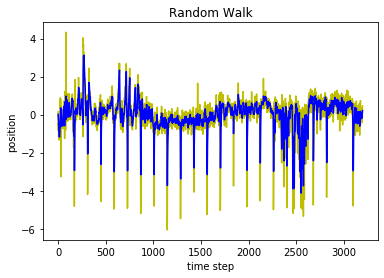

In [15]:
kf = Simple_Kalman(observed_position, start_position=0, start_deviation=1, deviation_true=1, deviation_noise=10)
#plt.plot(true_position, 'r--', label='True Positions')
plt.plot(observed_position, 'y', label='Observed Ppositions')
plt.plot(kf.x_, 'blue' ,label='Foward Estimation')
#plt.plot(kf.x_all_, 'black', label='Smoothed Estimation')
plt.title('Random Walk')
plt.xlabel('time step')
plt.ylabel('position')
#plt.legend(loc='best')

In [16]:
data1sample=np.array([124,246,372,460,485])
for j in enumerate(data1sample):
    shape=data1sample.shape
    i=j[1:2] #importance! 2d array->1d array
    print(i)
    
for j in enumerate(data1sample):
    shape=data1sample.shape
    i=j[1:2] #importance! 2d array->1d array
    print(j)

(124,)
(246,)
(372,)
(460,)
(485,)
(0, 124)
(1, 246)
(2, 372)
(3, 460)
(4, 485)
